In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_recall_curve, auc, accuracy_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB

import matplotlib.pyplot as plt
import seaborn as sns # plotting problem

!pip install contractions
import contractions # expanding contractions in text can't -> cannot

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 5.4 MB/s eta 0:00:00
/kaggle/input/amazon-product-review-spam-and-non-spam/Home_and_Kitchen/Home_and_Kitchen.json
/kaggle/input/amazon-product-review-spam-and-non-spam/part.json/part.json
/kaggle/input/amazon-product-review-spam-and-non-spam/Electronics/Electronics.json
/kaggle/input/amazon-product-review-spam-and-non-spam/separate.json/separate.json
/kaggle/input/amazon-product-review-spam-and-non-spam/Clothing_Shoes_and_Jewelry/Clothing_Shoes_and_Jewelry.json
/kaggle/input/amazon-product-review-spam-and-non-spam/Sports_and_Outdoors/Sports_and_Outdoors.json
/kaggle/input/amazon-product-review-spam-and-non-spam/Cell_Phones_and_Accessories/Cell_Phones_and_Accessories.json
/kaggle/input/amazon-product-review-spam-and-non-spam/Toys_and_Games/Toys_and_Games.json


## Dataset

In [2]:
df = pd.read_json('/kaggle/input/amazon-product-review-spam-and-non-spam/Toys_and_Games/Toys_and_Games.json', lines=True)
df

,_id,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,category,class
0,{'$oid': '5a13282b741a2384e879a620'},A3C9CSW3TJITGT,0005069491,Renee,"[0, 0]",I love these felt nursery rhyme characters and...,4,Charming characters but busy work required,1377561600,"08 27, 2013",Toys_and_Games,1
1,{'$oid': '5a13282b741a2384e879a621'},A31POTIYCKSZ9G,0076561046,So CA Teacher,"[0, 0]",I see no directions for its use. Therefore I h...,3,No directions for use...,1404864000,"07 9, 2014",Toys_and_Games,0
2,{'$oid': '5a13282b741a2384e879a622'},A2GGHHME9B6W4O,0131358936,Dalilah G.,"[0, 0]",This is a great tool for any teacher using the...,5,Great CD-ROM,1382400000,"10 22, 2013",Toys_and_Games,1
3,{'$oid': '5a13282b741a2384e879a61f'},AMEVO2LY6VEJA,0000191639,Nicole Soeder,"[0, 0]","Great product, thank you! Our son loved the pu...",5,Puzzles,1388016000,"12 26, 2013",Toys_and_Games,1
4,{'$oid': '5a13282b741a2384e879a623'},A1FSLDH43ORWZP,0133642984,Dayna English,"[0, 0]",Although not as streamlined as the Algebra I m...,5,Algebra II -- presentation materials,1374278400,"07 20, 2013",Toys_and_Games,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1997135,{'$oid': '5a132892741a2384e89c0ee4'},A3SDSFPFY8WS8C,B00LRXEK4G,"ben brightman ""benbrightman""","[2, 4]",Donny looks awesome in his wizard outfit. It r...,4,Awesome toy Price not Awesome,1405209600,"07 13, 2014",Toys_and_Games,1
1997136,{'$oid': '5a132892741a2384e89c0ee2'},AVJ4N5LBKAOG5,B00LOYLHOE,Gary P.,"[2, 3]","When I was a kid, I always heard, and sometime...",5,Excellent quality and fun to fly. Certainly wo...,1405123200,"07 12, 2014",Toys_and_Games,1
1997137,{'$oid': '5a132892741a2384e89c0ee6'},A3JB0C3QWIN61Q,B00LXACM5W,Moms of Three,"[0, 0]",The kids had hours and hours of fun with this....,5,Great Set!,1405900800,"07 21, 2014",Toys_and_Games,1
1997138,{'$oid': '5a132892741a2384e89c0ee5'},AJ062DSRHW9RX,B00LXACM5W,Braindel Schwartz,"[0, 0]",this pack of water shooters and splash balls a...,5,I bought a few packs for a birthday party and ...,1405814400,"07 20, 2014",Toys_and_Games,1


In [3]:
df.columns

Index(['_id', 'reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime', 'category',
       'class'],
      dtype='object')

In [4]:
df['class'].value_counts()

class
1    1662754
0     334386
Name: count, dtype: int64

In [5]:
df['class'].value_counts() / len(df)

class
1    0.832568
0    0.167432
Name: count, dtype: float64

In [6]:
df.iloc[3]['reviewText']

'Great product, thank you! Our son loved the puzzles.  They have large pieces yet they are still challenging for a 4 year old.'

In [7]:
leng_review = df.reviewText.str.len()
type(leng_review)

pandas.core.series.Series

In [8]:
leng_review

0           653
1            86
2           171
3           125
4           160
           ... 
1997135     606
1997136    1242
1997137     143
1997138     264
1997139     294
Name: reviewText, Length: 1997140, dtype: int64

In [9]:
max(leng_review)

32427

## Data preprocessing

In [10]:
df = df.head(100000)

In [11]:
df = df.loc[:, ['reviewText', 'class']]
df

,reviewText,class
0,I love these felt nursery rhyme characters and...,1
1,I see no directions for its use. Therefore I h...,0
2,This is a great tool for any teacher using the...,1
3,"Great product, thank you! Our son loved the pu...",1
4,Although not as streamlined as the Algebra I m...,1
...,...,...
99995,Received this product in a timely fashion. I m...,0
99996,McFarlane Sports Series are fantastic and life...,1
99997,Fortune is a good figure. She has a very attra...,1
99998,I just thought that I'd jot a few words to let...,0


In [12]:
df['class'].value_counts()

class
1    86465
0    13535
Name: count, dtype: int64

In [13]:
df['reviewText'] = df['reviewText'].apply(lambda x: contractions.fix(x))
df.loc[:, 'reviewText'] = df['reviewText'].str.lower()

# \W represents Special characters like "$" and "!!!"
df.loc[:, 'reviewText'] = df['reviewText'].str.replace('\W', ' ')

# \d represents Numeric digits like "19.99"
df.loc[:, 'reviewText'] = df['reviewText'].str.replace('\d', ' ')

df

,reviewText,class
0,i love these felt nursery rhyme characters and...,1
1,i see no directions for its use. therefore i h...,0
2,this is a great tool for any teacher using the...,1
3,"great product, thank you! our son loved the pu...",1
4,although not as streamlined as the algebra i m...,1
...,...,...
99995,received this product in a timely fashion. i m...,0
99996,mcfarlane sports series are fantastic and life...,1
99997,fortune is a good figure. she has a very attra...,1
99998,i just thought that i would jot a few words to...,0


In [14]:
def pr_auc_score(y_test, y_pred):
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall, precision)
    return pr_auc

In [15]:
def testModel(model, x_train, x_test):
    global y_test, y_train
    model.fit(x_train, y_train)
    pred = model.predict(x_test)

    score = accuracy_score(y_test, pred)
    print(score)

    pr_score = pr_auc_score(y_test, pred)
    print(pr_score)

    cm = confusion_matrix(y_test, pred, labels=[0, 1])
    print(cm)

In [16]:
# from nltk import word_tokenize

# # Tokenize each item in the review column 
# word_tokens = [word_tokenize(review) for review in df.reviewText]
# # Create an empty list to store the length of reviews
# len_tokens = []

# # Iterate over the word_tokens list and determine the length of each item
# for i in range(len(word_tokens)):
#      len_tokens.append(len(word_tokens[i]))

# # Create a new feature for the lengh of each review
# df['n_words'] = len_tokens 
# # very long time running ? think other ways

#### CountVectorizer test with max_features and ngram_range

In [17]:
# Create a series to store the labels: y
y = df['class']

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(df['reviewText'], y, test_size=0.33, random_state=21)

# Initialize a CountVectorizer object: count_vectorizer
count_vectorizer = CountVectorizer(stop_words='english', max_df = 0.8, max_features = 2000)

# Transform the training data using only the 'text' column values: count_train 
count_train = count_vectorizer.fit_transform(X_train)

# Transform the test data using only the 'text' column values: count_test 
count_test = count_vectorizer.transform(X_test)

In [18]:
len(count_vectorizer.get_feature_names_out())

2000

In [19]:
# Instantiate a Multinomial Naive Bayes classifier: nb_classifier
nb_classifier = MultinomialNB()

testModel(nb_classifier, count_train, count_test)

0.8765454545454545
0.9653009876243847
[[ 2818  1602]
 [ 2472 26108]]


In [20]:
from sklearn.tree import DecisionTreeClassifier

# Initialize the DecisionTreeClassifier
decision_tree = DecisionTreeClassifier()

testModel(decision_tree, count_train, count_test)
# running time very very long 

0.8447272727272728
0.9486841460965585
[[ 1817  2603]
 [ 2521 26059]]


In [21]:
from sklearn.linear_model import LogisticRegression

# Initialize the logistic regression model
logistic_regression = LogisticRegression(max_iter = 400) #Maximum number of iterations taken for the solvers to converge

testModel(logistic_regression, count_train, count_test)

0.9062727272727272
0.9598372301577586
[[ 2113  2307]
 [  786 27794]]


In [22]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the RandomForestClassifier with default parameters
random_forest = RandomForestClassifier()

testModel(random_forest, count_train, count_test)

0.8938787878787878
0.9485457345259153
[[ 1228  3192]
 [  310 28270]]


In [23]:
from sklearn.svm import LinearSVC

# Initialize the LinearSVC model
linear_svc = LinearSVC()

testModel(linear_svc, count_train, count_test)

0.905
0.9581865986361813
[[ 1984  2436]
 [  699 27881]]


/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [24]:
from sklearn.linear_model import Perceptron

# Initialize the Perceptron model
perceptron = Perceptron()

testModel(perceptron, count_train, count_test)

0.8841515151515151
0.9581166696065478
[[ 2191  2229]
 [ 1594 26986]]


In [25]:
import xgboost as xgb

# Convert your data into DMatrix format, which is optimized for XGBoost
dtrain = xgb.DMatrix(count_train, label=y_train)

# Set the parameters for the XGBoost model
params = {
    'objective': 'binary:logistic',  # Assuming binary classification
    'eval_metric': 'logloss'  # Use log loss as the evaluation metric
}

# Train the XGBoost model
num_rounds = 500  # Number of boosting rounds
xgb_model = xgb.train(params, dtrain, num_rounds)

dtest = xgb.DMatrix(count_test)

# Make predictions on the test data
y_pred_proba = xgb_model.predict(dtest)  # Predict probabilities
y_pred = [1 if pred > 0.5 else 0 for pred in y_pred_proba]  # Convert probabilities to binary predictions

score = accuracy_score(y_test, y_pred)
print(score)

pr_score = pr_auc_score(y_test, y_pred)
print(pr_score)
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
print(cm)

0.9094242424242425
0.9597122721369789
[[ 2070  2350]
 [  639 27941]]


In [26]:
# 0.8797751939513577
# 0.9604416985078744
# [[ 74773  35569]
#  [ 43666 505049]]
# ngram_range=(min,max) in CountVectorizer, (2,2) 0.8672982761733811, 0.9460343957068968

#### TfidfVectorizer test with max_features 

In [27]:
# Initialize a TfidfVectorizer object: tfidf_vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words="english", max_df=0.8, max_features=2000)

# Transform the training data: tfidf_train 
tfidf_train = tfidf_vectorizer.fit_transform(X_train) 

# Transform the test data: tfidf_test 
tfidf_test = tfidf_vectorizer.transform(X_test)

In [28]:
nb_classifier = MultinomialNB()

testModel(nb_classifier, tfidf_train, tfidf_test)

0.8860606060606061
0.9429143774048497
[[  769  3651]
 [  109 28471]]


In [29]:
from sklearn.tree import DecisionTreeClassifier

# Initialize the DecisionTreeClassifier
decision_tree = DecisionTreeClassifier()

testModel(decision_tree, tfidf_train, tfidf_test)
# running time very very long 

0.8409090909090909
0.9475324193015844
[[ 1762  2658]
 [ 2592 25988]]


In [30]:
from sklearn.linear_model import LogisticRegression

# Initialize the logistic regression model
logistic_regression = LogisticRegression(max_iter = 400) #Maximum number of iterations taken for the solvers to converge

testModel(logistic_regression, tfidf_train, tfidf_test)

0.9096363636363637
0.9587239667915386
[[ 1982  2438]
 [  544 28036]]


In [31]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the RandomForestClassifier with default parameters
random_forest = RandomForestClassifier()

testModel(random_forest, tfidf_train, tfidf_test)

0.8926363636363637
0.947663847070314
[[ 1158  3262]
 [  281 28299]]


In [32]:
from sklearn.svm import LinearSVC

# Initialize the LinearSVC model
linear_svc = LinearSVC()

testModel(linear_svc, tfidf_train, tfidf_test)

0.9103333333333333
0.9604612370877422
[[ 2125  2295]
 [  664 27916]]


In [33]:
from sklearn.linear_model import Perceptron

# Initialize the Perceptron model
perceptron = Perceptron()

testModel(perceptron, tfidf_train, tfidf_test)

0.8693939393939394
0.9570367111671463
[[ 2248  2172]
 [ 2138 26442]]


In [34]:
import xgboost as xgb

# Convert your data into DMatrix format, which is optimized for XGBoost
dtrain = xgb.DMatrix(tfidf_train, label=y_train)

# Set the parameters for the XGBoost model
params = {
    'objective': 'binary:logistic',  # Assuming binary classification
    'eval_metric': 'logloss'  # Use log loss as the evaluation metric
}

# Train the XGBoost model
num_rounds = 500  # Number of boosting rounds
xgb_model = xgb.train(params, dtrain, num_rounds)

dtest = xgb.DMatrix(tfidf_test)

# Make predictions on the test data
y_pred_proba = xgb_model.predict(dtest)  # Predict probabilities
y_pred = [1 if pred > 0.5 else 0 for pred in y_pred_proba]  # Convert probabilities to binary predictions

score = accuracy_score(y_test, y_pred)
print(score)

pr_score = pr_auc_score(y_test, y_pred)
print(pr_score)
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
print(cm)

0.9066060606060606
0.9583809021321104
[[ 1984  2436]
 [  646 27934]]


### CountVectorizer approach

In [35]:
#BOW

# Initialize a CountVectorizer object: count_vectorizer
count_vectorizer = CountVectorizer(stop_words='english')

# Transform the training data using only the 'text' column values: count_train 
count_train = count_vectorizer.fit_transform(X_train)

# Transform the test data using only the 'text' column values: count_test 
count_test = count_vectorizer.transform(X_test)

In [36]:
count_vectorizer.get_feature_names_out()[:10]

array(['00', '000', '000g', '001', '0021', '0029', '006602', '0069',
       '007', '007banjo'], dtype=object)

In [37]:
len(count_vectorizer.get_feature_names_out())

51685

In [38]:
count_train

<67000x51685 sparse matrix of type '<class 'numpy.int64'>'
	with 1887007 stored elements in Compressed Sparse Row format>

### TfidfVectorizer approach

In [39]:
# Initialize a TfidfVectorizer object: tfidf_vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words="english", max_df=0.7)

# Transform the training data: tfidf_train 
tfidf_train = tfidf_vectorizer.fit_transform(X_train) 

# Transform the test data: tfidf_test 
tfidf_test = tfidf_vectorizer.transform(X_test)

In [40]:
len(tfidf_vectorizer.get_feature_names_out())

51685

In [41]:
tfidf_vectorizer.get_feature_names_out()[:10]

array(['00', '000', '000g', '001', '0021', '0029', '006602', '0069',
       '007', '007banjo'], dtype=object)

In [42]:
tfidf_train

<67000x51685 sparse matrix of type '<class 'numpy.float64'>'
	with 1887007 stored elements in Compressed Sparse Row format>

#### Model test Count

In [43]:
# Instantiate a Multinomial Naive Bayes classifier: nb_classifier
nb_classifier = MultinomialNB()

# Fit the classifier to the training data
nb_classifier.fit(count_train, y_train)

# Create the predicted tags: pred
pred = nb_classifier.predict(count_test)

# Calculate the accuracy score: score
score = accuracy_score(y_test, pred)
print(score)

pr_score = pr_auc_score(y_test, pred)
print(pr_score)
# Calculate the confusion matrix: cm
cm = confusion_matrix(y_test, pred, labels=[0, 1])
print(cm)

0.8964848484848484
0.9617608207641024
[[ 2369  2051]
 [ 1365 27215]]


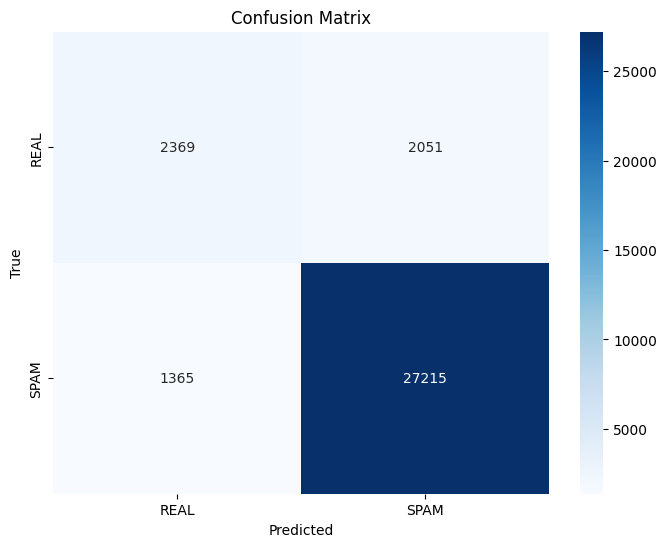

In [44]:
class_labels = ['REAL', 'SPAM']
# Plot confusion matrix
def plot_cmatrix(cm, class_labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
plot_cmatrix(cm, class_labels)

#### Model test tf-idf

In [45]:
# Fit the classifier to the training data
nb_classifier.fit(tfidf_train, y_train)

# Create the predicted tags: pred
pred = nb_classifier.predict(tfidf_test)

# Calculate the accuracy score: score
score = accuracy_score(y_test, pred)
print(score)

pr_score = pr_auc_score(y_test, pred)
print(pr_score)
# Calculate the confusion matrix: cm
cm = confusion_matrix(y_test, pred, labels=[0, 1])
print(cm)

0.8664545454545455
0.933244795932389
[[   18  4402]
 [    5 28575]]


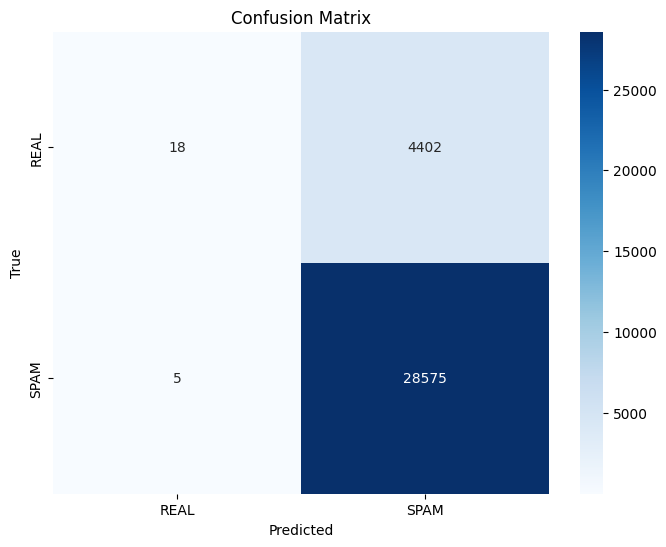

In [46]:
plot_cmatrix(cm, class_labels)

#### Count + Tf-IDF

In [47]:
# Limiting the vocabulary size
vectorizer = CountVectorizer(stop_words='english', max_df=0.8,max_features=100000)
X_counts_train = vectorizer.fit_transform(X_train)
X_counts_test = vectorizer.transform(X_test)

# Applying TF-IDF transformation
tfidf_transformer = TfidfTransformer()
X_cb_train = tfidf_transformer.fit_transform(X_counts_train)
X_cb_test = tfidf_transformer.transform(X_counts_test)

In [48]:
print(len(tfidf_transformer.get_feature_names_out()))

51685


In [49]:
X_cb_train

<67000x51685 sparse matrix of type '<class 'numpy.float64'>'
	with 1887007 stored elements in Compressed Sparse Row format>

In [50]:
# X_cb_train.A[:5]

In [51]:
# cb_df = pd.DataFrame(X_cb_train.toarray(), columns=tfidf_transformer.get_feature_names_out())
# cb_df

In [52]:
# Fit the classifier to the training data
nb_classifier.fit(X_cb_train, y_train)

# Create the predicted tags: pred
pred = nb_classifier.predict(X_cb_test)

# Calculate the accuracy score: score
score = accuracy_score(y_test, pred)
print(score)

pr_score = pr_auc_score(y_test, pred)
print(pr_score)
# Calculate the confusion matrix: cm
cm = confusion_matrix(y_test, pred, labels=[0, 1])
print(cm)

0.8664545454545455
0.933244795932389
[[   18  4402]
 [    5 28575]]


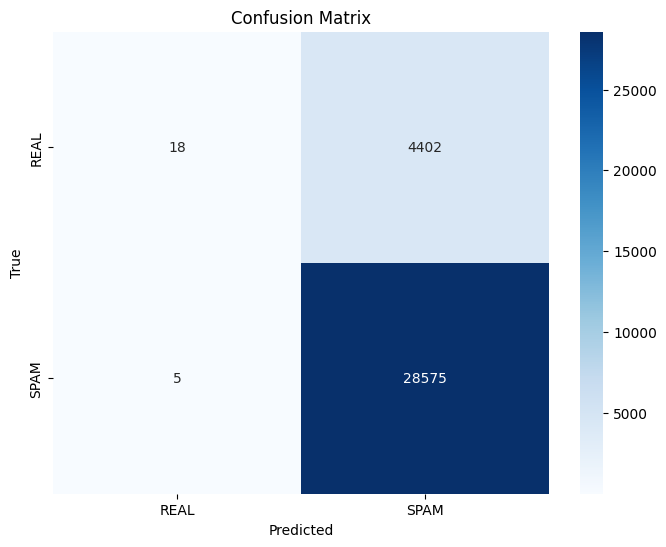

In [53]:
plot_cmatrix(cm, class_labels)

In [54]:
# Create the list of alphas
alphas = np.arange(0, 1, 0.1)

# Define the parameter grid
param_grid = {'alpha': alphas}


# Instantiate GridSearchCV
grid_search = GridSearchCV(estimator=nb_classifier, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_cb_train, y_train)

# Print the best alpha value found
print("Best Alpha:", grid_search.best_params_['alpha'])

/opt/conda/lib/python3.10/site-packages/sklearn/naive_bayes.py:629: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/naive_bayes.py:629: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/naive_bayes.py:629: FutureWarning: The default val

Best Alpha: 0.1


In [55]:
nb_classifier = MultinomialNB(alpha=0.1)

# Fit the classifier to the training data
nb_classifier.fit(X_cb_train, y_train)

# Create the predicted tags: pred
pred = nb_classifier.predict(X_cb_test)

# Calculate the accuracy score: score
score = accuracy_score(y_test, pred)
print(score)

pr_score = pr_auc_score(y_test, pred)
print(pr_score)
# Calculate the confusion matrix: cm
cm = confusion_matrix(y_test, pred, labels=[0, 1])
print(cm)

0.8872727272727273
0.9441913418023535
[[  883  3537]
 [  183 28397]]


In [56]:
# Create the list of alphas
alphas = np.arange(0, 1, 0.1)

# Define the parameter grid
param_grid = {'alpha': alphas}


# Instantiate GridSearchCV
grid_search = GridSearchCV(estimator=nb_classifier, param_grid=param_grid, cv=5, scoring='roc_auc')

# Fit the grid search to the data
grid_search.fit(X_cb_train, y_train)

# Print the best alpha value found
print("Best Alpha:", grid_search.best_params_['alpha'])

/opt/conda/lib/python3.10/site-packages/sklearn/naive_bayes.py:629: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/naive_bayes.py:629: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/naive_bayes.py:629: FutureWarning: The default val

Best Alpha: 0.1


In [57]:
nb_classifier = MultinomialNB(alpha=0.3)

# Fit the classifier to the training data
nb_classifier.fit(X_cb_train, y_train)

# Create the predicted tags: pred
pred = nb_classifier.predict(X_cb_test)

# Calculate the accuracy score: score
score = accuracy_score(y_test, pred)
print(score)

pr_score = pr_auc_score(y_test, pred)
print(pr_score)
# Calculate the confusion matrix: cm
cm = confusion_matrix(y_test, pred, labels=[0, 1])
print(cm)

0.8771515151515151
0.9385045416211967
[[  433  3987]
 [   67 28513]]
